## Librerias

In [134]:
library(dplyr)
library(ggplot2)
library(MASS)
library(car)
library(broom)
library(hnp)

## Data

In [135]:
data <- read.csv("../data/processed/tabla_severidad.csv")
data$X <- NULL

In [136]:
head(data)

,Modelo,Color,Carroceria,CLASE_FASECOLDA,TIPO_VEHICULO,SERVICIO,Sexo_Aseg,Edad,valor,n_siniestros,exposicion_total,suma_pagos,n_observaciones,severidad_media
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>
1,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,F,19_41,101517338,2,2410,8014069,13,4007034.6
2,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,F,41_63,197695502,2,3862,2204046,22,1102023.2
3,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,19_41,180459141,4,4223,6450375,23,1612593.7
4,1993_1999,BLANCO,SEDAN,AUTOMOVIL,Livianos,Particular,M,41_63,121930553,2,3077,4238816,16,2119408.0
5,1993_1999,Otros,Otros,Otros,Livianos,Particular,F,41_63,79750398,2,1099,1208679,6,604339.6
6,1993_1999,Otros,SEDAN,AUTOMOVIL,Livianos,Particular,F,19_41,338559951,2,6132,8213167,35,4106583.6


In [137]:
summary(data$suma_pagos)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   114915   2965280   6455237  14091604  14368452 121532938 

## Seleccion de variables

In [138]:
establecer_categorias_referencia <- function(df, vars_categoricas, var_exposicion = "exposicion_total") {
  df_copy <- df
  
  for (var in vars_categoricas) {
    exposicion_por_categoria <- aggregate(df_copy[[var_exposicion]], 
                                        by = list(df_copy[[var]]), 
                                        FUN = sum, na.rm = TRUE)
    names(exposicion_por_categoria) <- c("categoria", "exposicion_total")
    
    categoria_referencia <- exposicion_por_categoria$categoria[which.max(exposicion_por_categoria$exposicion_total)]
    
    cat("Variable:", var, "- Categoría de referencia:", categoria_referencia, "\n")
    
    df_copy[[var]] <- factor(df_copy[[var]])
    df_copy[[var]] <- relevel(df_copy[[var]], ref = as.character(categoria_referencia))
  }
  
  return(df_copy)
}

vars_categoricas <- c("Modelo", "Color", "Carroceria", "CLASE_FASECOLDA", 
                     "TIPO_VEHICULO", "SERVICIO", "Sexo_Aseg", "Edad")

data <- establecer_categorias_referencia(data, vars_categoricas)

str(data)

Variable: Modelo - Categoría de referencia: 2007_2013 
Variable: Color - Categoría de referencia: Otros 
Variable: Carroceria - Categoría de referencia: SEDAN 
Variable: CLASE_FASECOLDA - Categoría de referencia: AUTOMOVIL 
Variable: TIPO_VEHICULO - Categoría de referencia: Livianos 
Variable: SERVICIO - Categoría de referencia: Particular 
Variable: Sexo_Aseg - Categoría de referencia: M 
Variable: Edad - Categoría de referencia: 41_63 
'data.frame':	178 obs. of  14 variables:
 $ Modelo          : Factor w/ 3 levels "2007_2013","1993_1999",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Color           : Factor w/ 4 levels "Otros","AMARILLO",..: 3 3 3 3 1 1 1 1 1 1 ...
 $ Carroceria      : Factor w/ 4 levels "SEDAN","CABINADO",..: 1 1 1 1 4 1 1 1 1 1 ...
 $ CLASE_FASECOLDA : Factor w/ 4 levels "AUTOMOVIL","AUTOMOVIL TAXI",..: 1 1 1 1 4 1 1 1 1 1 ...
 $ TIPO_VEHICULO   : Factor w/ 2 levels "Livianos","Pesados": 1 1 1 1 1 1 1 1 1 1 ...
 $ SERVICIO        : Factor w/ 4 levels "Particular","Oficial",..: 1

## FRECUENCIA 

In [139]:
# Modelo inicial con todas las variables (Poisson)
modelo_inicial <- glm(
  n_siniestros ~ log(valor) + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
                 TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Edad + 
                 offset(log(exposicion_total)),
  family = poisson,
  data = data
)

# Modelo inicial con todas las variables (Poisson)
modelo_nulo <- glm(
  n_siniestros ~ 1,
  family = poisson,
  data = data
)

# Selección stepwise
modelo_stepwise <- step(modelo_inicial, direction = "forward", trace = FALSE)

# Mostrar la fórmula seleccionada
cat("Fórmula seleccionada por stepwise:\n")
print(formula(modelo_stepwise))

# Crear modelo final con Quasi-Poisson especificando la fórmula explícitamente
modelo_frecuencia_final <- update(modelo_stepwise, family = quasipoisson)

# Resumen del modelo final
summary(modelo_frecuencia_final)

Fórmula seleccionada por stepwise:
n_siniestros ~ log(valor) + Modelo + Color + Carroceria + CLASE_FASECOLDA + 
    TIPO_VEHICULO + SERVICIO + Sexo_Aseg + Edad + offset(log(exposicion_total))



Call:
glm(formula = n_siniestros ~ log(valor) + Modelo + Color + Carroceria + 
    CLASE_FASECOLDA + TIPO_VEHICULO + SERVICIO + Sexo_Aseg + 
    Edad + offset(log(exposicion_total)), family = quasipoisson, 
    data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.23623  -0.45818   0.04763   0.48402   2.40406  

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   -2.78455    0.96940  -2.872  0.00464 ** 
log(valor)                    -0.21271    0.04278  -4.972 1.73e-06 ***
Modelo1993_1999               -0.30602    0.20547  -1.489  0.13841    
Modelo2000_2006               -0.02660    0.11612  -0.229  0.81910    
ColorAMARILLO                 -0.44186    0.38150  -1.158  0.24854    
ColorBLANCO                   -0.27614    0.10405  -2.654  0.00878 ** 
ColorPLATA                    -0.02250    0.08415  -0.267  0.78956    
CarroceriaCABINADO            -0.14208    0.19940  -0.713  0.47721  

Se deja solo log(valor), carroceria, edad, sexo y color

In [140]:
modelo_frecuencia_final <- glm(
  n_siniestros ~ log(valor) + Color + Carroceria + Sexo_Aseg + Edad + offset(log(exposicion_total)),
  family = quasipoisson,
  data = data
)

## Evaluación

In [141]:
# Verificar sobredispersión
dispersion <- sum(residuals(modelo_frecuencia_final, type = "pearson")^2) / modelo_frecuencia_final$df.residual
cat("Parámetro de dispersión:", dispersion, "\n")

if (dispersion > 1.5) {
  cat("ADVERTENCIA: Hay evidencia de sobredispersión. Considerar modelo quasi-Poisson o binomial negativa.\n")
} else {
  cat("La dispersión parece apropiada para el modelo Poisson.\n")
}

Parámetro de dispersión: 0.7578623 
La dispersión parece apropiada para el modelo Poisson.


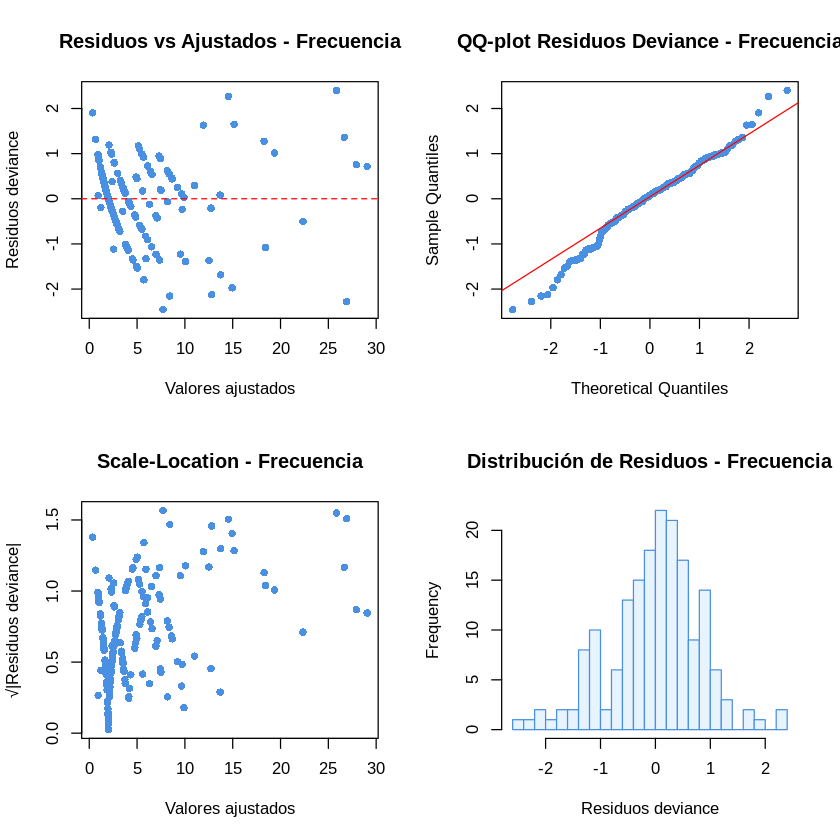

In [142]:
# Gráficos diagnósticos para el modelo de frecuencia
residuos_deviance <- residuals(modelo_frecuencia_final, type = "deviance")
residuos_pearson <- residuals(modelo_frecuencia_final, type = "pearson")
valores_ajustados <- fitted(modelo_frecuencia_final)

# Panel de diagnósticos (4 gráficos)
par(mfrow = c(2, 2))

# Residuos vs valores ajustados
plot(valores_ajustados, residuos_deviance,
     xlab = "Valores ajustados", 
     ylab = "Residuos deviance",
     main = "Residuos vs Ajustados - Frecuencia",
     pch = 16, col = "#4A90E2")
abline(h = 0, col = "red", lty = 2)

# QQ-plot de residuos
qqnorm(residuos_deviance, 
       main = "QQ-plot Residuos Deviance - Frecuencia",
       pch = 16, col = "#4A90E2")
qqline(residuos_deviance, col = "red")

# Scale-Location
plot(valores_ajustados, sqrt(abs(residuos_deviance)),
     xlab = "Valores ajustados",
     ylab = "√|Residuos deviance|",
     main = "Scale-Location - Frecuencia",
     pch = 16, col = "#4A90E2")

# Histograma de residuos
hist(residuos_deviance, 
     breaks = 30,
     main = "Distribución de Residuos - Frecuencia",
     xlab = "Residuos deviance",
     col = "#E8F4FD",
     border = "#4A90E2")

par(mfrow = c(1, 1))

Quasi-Poisson model 


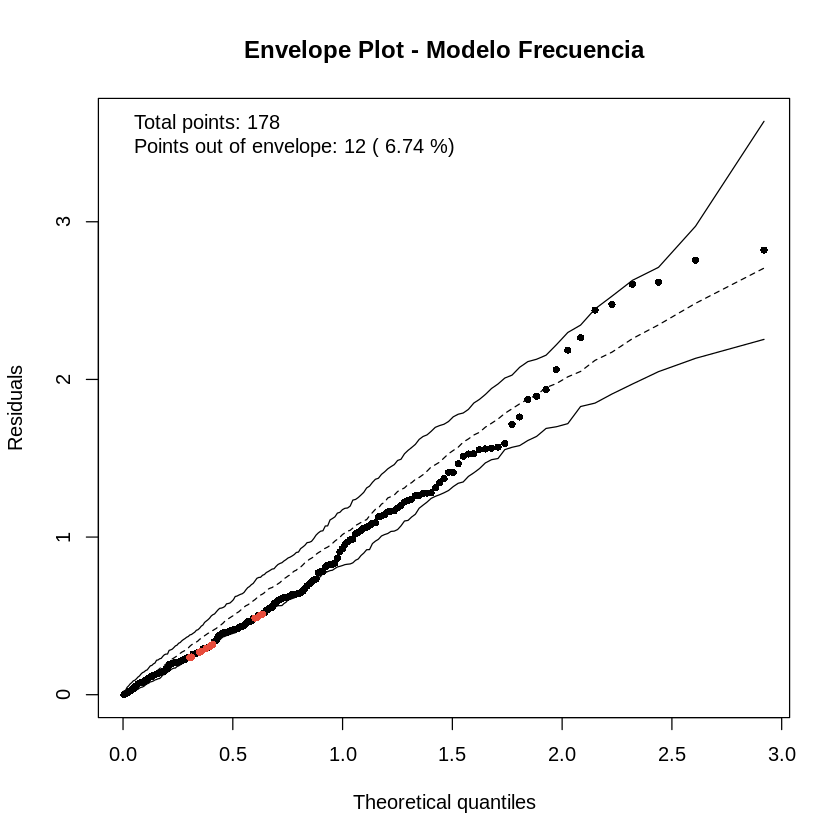

In [143]:
set.seed(122)

envelope_frecuencia <- hnp(modelo_frecuencia_final, 
                     sim = 99,           # Número de simulaciones
                     conf = 0.95,        # Nivel de confianza
                     halfnormal = TRUE,  # Gráfico half-normal
                     scale = TRUE,       # Escalar residuos
                     plot.sim = TRUE,    # Mostrar simulaciones
                     verb.sim = FALSE,   # Sin output verbose
                     how.many.out = TRUE,# Contar outliers
                     print.on = TRUE,    # Imprimir estadísticas
                     paint.out = TRUE,   # Colorear outliers
                     main = "Envelope Plot - Modelo Frecuencia",
                     col.paint.out = "#E74C3C",
                     pch = 16,
                     cex = 0.8)

## Diagnóstico del ajuste del modelo

In [144]:
# Análisis detallado del problema
cat("=== DIAGNÓSTICO DEL MODELO ===\n")
cat("Dispersión:", dispersion, "\n")
cat("Deviance/df:", deviance(modelo_frecuencia_final)/modelo_frecuencia_final$df.residual, "\n")

# Verificar distribución de la variable respuesta
cat("\n=== DISTRIBUCIÓN DE n_siniestros ===\n")
table(data$n_siniestros)

# Verificar ceros excesivos
prop_ceros <- sum(data$n_siniestros == 0) / nrow(data)
cat("\nProp. de ceros:", round(prop_ceros, 3), "\n")

# Verificar valores ajustados vs observados
mu_hat <- fitted(modelo_frecuencia_final)
cat("Rango valores ajustados:", round(range(mu_hat), 3), "\n")
cat("Media n_siniestros:", round(mean(data$n_siniestros), 3), "\n")

=== DIAGNÓSTICO DEL MODELO ===
Dispersión: 0.7578623 
Deviance/df: 0.7551219 

=== DISTRIBUCIÓN DE n_siniestros ===



 1  2  3  4  6  8  9 10 12 14 16 18 20 22 24 32 33 34 39 
 3 91  4 31 10 13  1  9  3  2  1  1  1  1  3  1  1  1  1 


Prop. de ceros: 0 
Rango valores ajustados: 0.355 29.062 
Media n_siniestros: 5.247 


## Exportar Modelos

In [145]:
# Guardar modelo de frecuencia simple
saveRDS(modelo_frecuencia_final, file = "../models/modelo_frecuencia_quasipoisson.rds")

# Guardar modelo con información adicional
modelo_frecuencia_info <- list(
  modelo = modelo_frecuencia_final,
  aic = AIC(modelo_frecuencia_final),
  formula = formula(modelo_frecuencia_final),
  family = "Quasi-Poisson",
  dispersion = summary(modelo_frecuencia_final)$dispersion,
  fecha_entrenamiento = Sys.Date()
)

saveRDS(modelo_frecuencia_info, file = "../models/modelo_frecuencia_quasipoisson_completo.rds")

cat("Modelos exportados exitosamente:\n")
cat("- modelo_frecuencia_quasipoisson.rds\n")
cat("- modelo_frecuencia_quasipoisson_completo.rds\n")

Modelos exportados exitosamente:
- modelo_frecuencia_quasipoisson.rds
- modelo_frecuencia_quasipoisson_completo.rds
